# Assignment 10 - Viraj Noorithaya


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-10" if code_mode == "development" else "main"
folder_name = "Session 10/Submission"

## Library Installation (Optional)

In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


## Code Procurement


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf "era-v1" && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "era-v1" && git checkout {branch_name} && cd "{folder_name}"

Cloning into 'era-v1'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1011 (delta 9), reused 12 (delta 5), pack-reused 984
Receiving objects: 100% (1011/1011), 6.43 MiB | 28.64 MiB/s, done.
Resolving deltas: 100% (502/502), done.
Branch 'week-10' set up to track remote branch 'week-10' from 'origin'.
Switched to a new branch 'week-10'


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder
from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import sys
print(f"CWD: {os.getcwd()}")

if model_run_location == 'colab':
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: /content
Appending folder to path in order to detect modules: Session 10/Submission


In [6]:
# Import user defined modules
from modules.dataset import split_cifar_data, apply_cifar_image_transformations
from modules.dataset import CIFAR_MEAN, CIFAR_STD, CIFAR_CLASSES
from modules.custom_resnet import CustomResNet as Net
from modules.trainer import train_and_test_model
from modules.utils import get_device, save_model, pretty_print_metrics
from modules.visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [7]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Specify the number of epochs
NUM_EPOCHS = 24

# Set the batch size
BATCH_SIZE = 512

# Set seed value for reproducibility
SEED = 8

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device


In [8]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [9]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# cutout needs to be half of the image size
cutout_size = 8

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=CIFAR_MEAN, std=CIFAR_STD, cutout_size=cutout_size
)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## Train/Test Split


In [10]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data



100%|██████████| 170498071/170498071 [00:02<00:00, 58346110.84it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [11]:
# For reproducibility
torch.manual_seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)

# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

In [12]:
# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


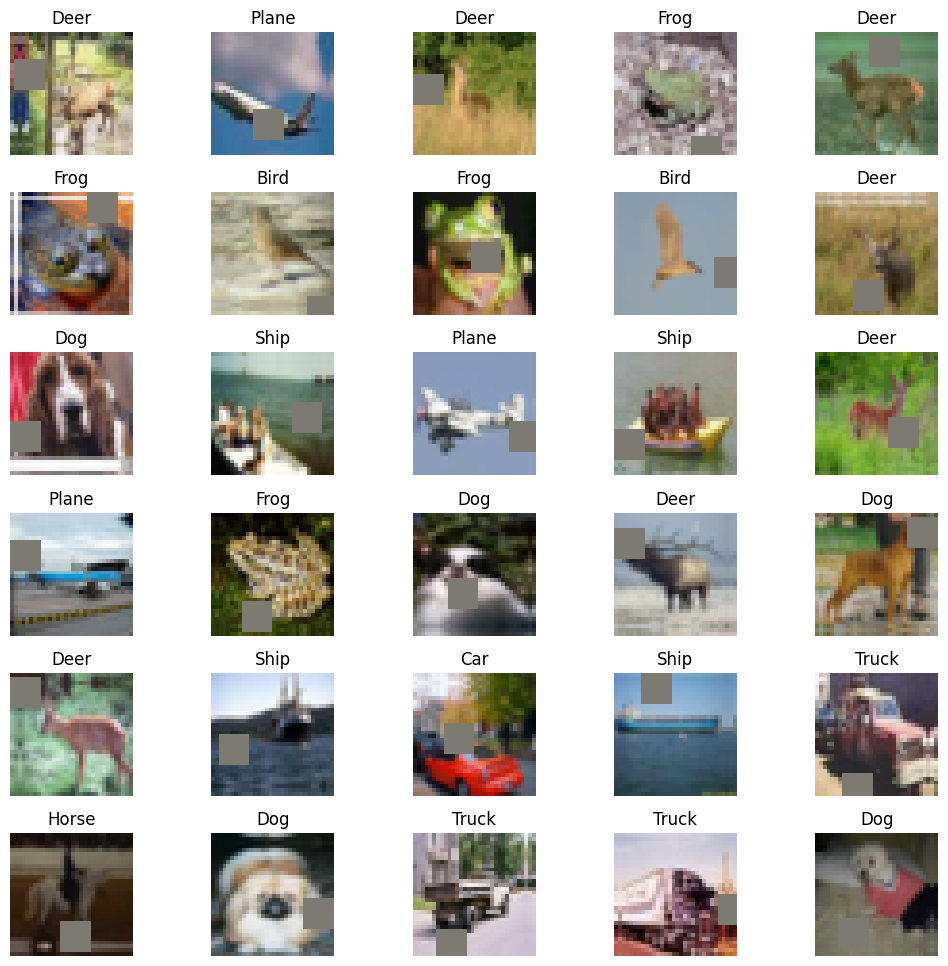

In [13]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [14]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# Print the model summary by specifying the input size
summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
 torch.Size([2, 64, 32, 32]) 

Layer 1, X 
 torch.Size([2, 128, 16, 16]) 

Layer 1, R1 
 torch.Size([2, 128, 16, 16]) 

Layer 1, X + R1 
 torch.Size([2, 128, 16, 16]) 

Layer 2 
 torch.Size([2, 256, 8, 8]) 

Layer 3, X 
 torch.Size([2, 512, 4, 4]) 

Layer 3, R2 
 torch.Size([2, 512, 4, 4]) 

Layer 3, X + R2 
 torch.Size([2, 512, 4, 4]) 

Max Pooling 
 torch.Size([2, 512, 1, 1]) 

Reshape before FC 
 torch.Size([2, 512]) 

After FC 
 torch.Size([2, 10]) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReL

## Train and Test


### Optimizer and Loss Function


In [15]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.64E-02


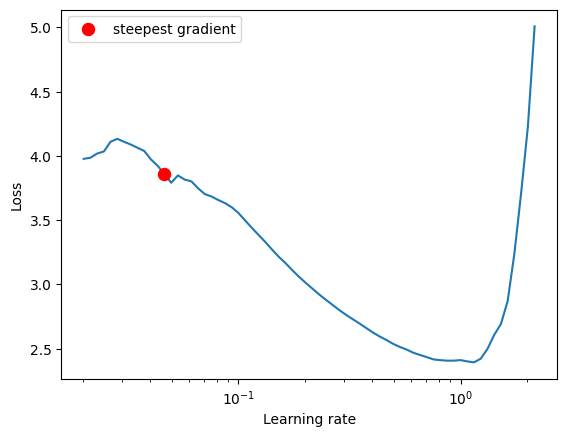

In [16]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader=train_loader, end_lr=10, num_iter=100)
plot, optimal_lr = lr_finder.plot(suggest_lr=True)
lr_finder.reset()

### Scheduler


In [17]:
# # Learning rate scheduler based on plateau
# # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
# )

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=optimal_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
    verbose=True,
)

Adjusting learning rate of group 0 to 4.6416e-04.


### Train and test model


In [18]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 24


Epoch 1


Train: Loss=1.0202, Batch_id=97, Accuracy=52.10: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]


Test set: Average loss: 0.0021,  Accuracy: 6291/10000  ({current_test_accuracy:.2f}%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 5.5813e-04.




In [19]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs = NUM_EPOCHS, results)

SyntaxError: ignored

## Metrics


In [ ]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()

## Save model


In [ ]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch,
    model,
    optimizer,
    scheduler,
    batch_size = BATCH_SIZE,
    criterion,
    file_name="model_last_epoch.pth",
)

## Show incorrect images


In [ ]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()